In [1]:
!pip install pandas
!pip install bertopic numpy tqdm pandas gdown
!pip install --upgrade tqdm
!pip install --upgrade umap-learn
!pip install numpy
import sys
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install wordcloud
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install bertopic umap-learn hdbscan tqdm pandas numpy gdown pyarrow seaborn
!pip install --upgrade pandas pyarrow fastparquet

In [2]:
import gdown
import os

# New, more reliable URL format for gdown
url = "https://drive.google.com/uc?id=15iWHLGQ5hdiV2pPKusnyu-yZZUVlWfbY"

output_filename = 'combined_data.db'
download_path = os.path.join(os.getcwd(), output_filename)

# Check and download the file
if os.path.exists(download_path):
    print(f"Warning: File '{output_filename}' already exists. Skipping download.")
else:
    gdown.download(url, output=download_path, quiet=False)
    print(f"Download of '{output_filename}' complete!")

# confirm file
if os.path.exists(download_path):
    print(f"'{output_filename}' found locally at {download_path}")

# Confirm file presence and size
if os.path.exists(download_path):
    file_size_bytes = os.path.getsize(download_path)
    file_size_gb = file_size_bytes / (1024**3)
    print(f"'{output_filename}' found locally. Size: {file_size_gb:.2f} GB")
    if file_size_gb < 1:
        print("Warning: Downloaded file size seems unusually small. Check if download was complete/successful.")
else:
    print("ERROR: Downloaded file not found after gdown command.")
    raise FileNotFoundError(f"Download target {download_path} not found.")

VAST_AI_DB_PATH = download_path
print(f"VAST_AI_DB_PATH set to: {VAST_AI_DB_PATH}")

'combined_data.db' found locally at /workspace/combined_data.db
'combined_data.db' found locally. Size: 0.56 GB
VAST_AI_DB_PATH set to: /workspace/combined_data.db


In [3]:
# Part 2: Connect to the database and load data
import sqlite3
import pandas as pd
print("\n--- Connecting to Database and Loading Data ---")
db_path = VAST_AI_DB_PATH
conn = None
try:
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT textOriginal FROM comments", conn)
    print("Data loaded successfully.")
    print(df.head())
except sqlite3.Error as e:
    print(f"Database error: {e}")
finally:
    if conn:
        conn.close()


--- Connecting to Database and Loading Data ---
Data loaded successfully.
                           textOriginal
0    please lesbian flag beg would rock
1  apply mashed potato juice mixed curd
2                     missed calls mars
3                                  baaa
4   look like raven phenomena raven cap


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import matplotlib.pyplot as plt

# Part 2: Connect to the database and load data
print("\n--- Connecting to Database and Loading Data ---")
db_path = VAST_AI_DB_PATH
conn = None
try:
    conn = sqlite3.connect(db_path)
    df = pd.read_sql_query("SELECT textOriginal FROM comments", conn)
    print("Data loaded successfully.")
    print(df.head())
except sqlite3.Error as e:
    print(f"Database error: {e}")
finally:
    if conn:
        conn.close()


--- Connecting to Database and Loading Data ---
Data loaded successfully.
                           textOriginal
0    please lesbian flag beg would rock
1  apply mashed potato juice mixed curd
2                     missed calls mars
3                                  baaa
4   look like raven phenomena raven cap


In [5]:
# Replace any missing text values with an empty string
df['textOriginal'] = df['textOriginal'].fillna('')

print("Cleaned data. Displaying head to confirm no missing values.")
print(df.head())

Cleaned data. Displaying head to confirm no missing values.
                           textOriginal
0    please lesbian flag beg would rock
1  apply mashed potato juice mixed curd
2                     missed calls mars
3                                  baaa
4   look like raven phenomena raven cap


In [6]:
# Part 3: Identify Trends with Topic Modeling
print("\n--- Identifying Trends with Topic Modeling ---")

# Download stopwords list 
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words=stop_words, max_df=0.85, min_df=5)
X = vectorizer.fit_transform(df['textOriginal'])

# Initialize KMeans with a number of topics (e.g., 5)
num_topics = 5
kmeans = KMeans(n_clusters=num_topics, random_state=42, n_init=10)
kmeans.fit(X)

# This is where the variables are created:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

# Assign a topic label to each comment
df['topic'] = kmeans.labels_

print("Variables 'order_centroids' and 'terms' are now available for visualization.")



--- Identifying Trends with Topic Modeling ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Variables 'order_centroids' and 'terms' are now available for visualization.


In [7]:
# Part 4: Conduct Sentiment Analysis
print("\n--- Conducting Sentiment Analysis ---")
nltk.download('vader_lexicon', quiet=True)
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['textOriginal'].apply(lambda text: sid.polarity_scores(str(text))['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'Positive' if score >= 0.05 else ('Negative' if score <= -0.05 else 'Neutral'))
print("Sentiment analysis complete.")
print(df.head())


--- Conducting Sentiment Analysis ---
Sentiment analysis complete.
                           textOriginal  topic  sentiment_score sentiment
0    please lesbian flag beg would rock      1           0.3182  Positive
1  apply mashed potato juice mixed curd      1           0.0000   Neutral
2                     missed calls mars      1          -0.2960  Negative
3                                  baaa      1           0.0000   Neutral
4   look like raven phenomena raven cap      0           0.3612  Positive



--- Analyzing and Visualizing Results ---
   topic  sentiment_score
0      0         0.350982
1      1         0.143199
2      2         0.246065
3      3         0.616192
4      4         0.679217


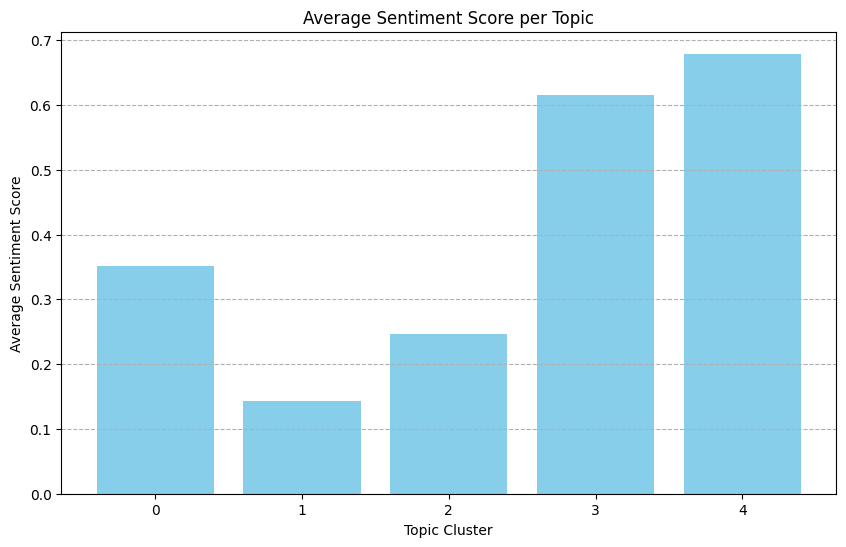

In [8]:
# Part 5: Analyze and Visualize the Results
print("\n--- Analyzing and Visualizing Results ---")
topic_sentiment = df.groupby('topic')['sentiment_score'].mean().reset_index()
print(topic_sentiment)

plt.figure(figsize=(10, 6))
plt.bar(topic_sentiment['topic'], topic_sentiment['sentiment_score'], color='skyblue')
plt.title('Average Sentiment Score per Topic')
plt.xlabel('Topic Cluster')
plt.ylabel('Average Sentiment Score')
plt.xticks(topic_sentiment['topic'])
plt.grid(axis='y', linestyle='--')
plt.show()

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# Get the cluster centroids from KMeans
cluster_centroids = kmeans.cluster_centers_

# Calculate the cosine similarity matrix between all clusters
similarity_matrix = cosine_similarity(cluster_centroids)

# Display the similarity scores
# The matrix shows the similarity of each cluster to every other cluster
print("Cosine Similarity Matrix between Clusters:")
print(pd.DataFrame(similarity_matrix).round(2))

Cosine Similarity Matrix between Clusters:
      0     1     2     3     4
0  1.00  0.37  0.16  0.16  0.05
1  0.37  1.00  0.18  0.17  0.07
2  0.16  0.18  1.00  0.05  0.02
3  0.16  0.17  0.05  1.00  0.08
4  0.05  0.07  0.02  0.08  1.00


Generating Word Clouds for each topic...


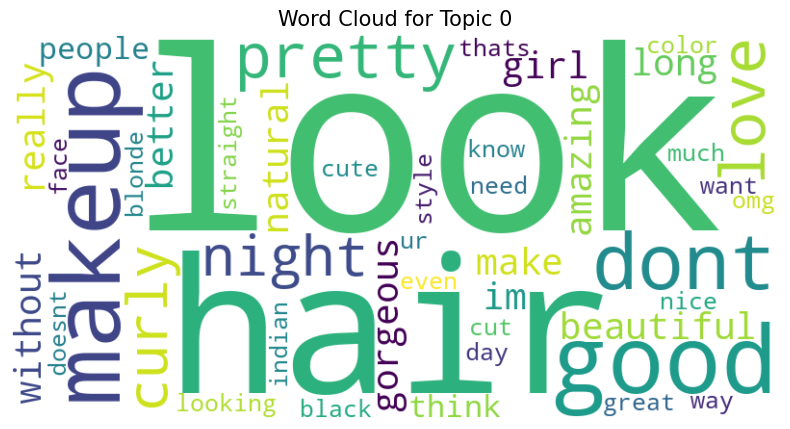

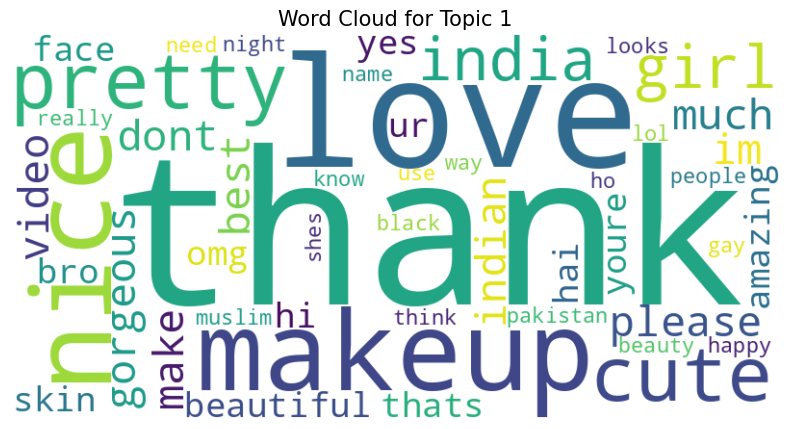

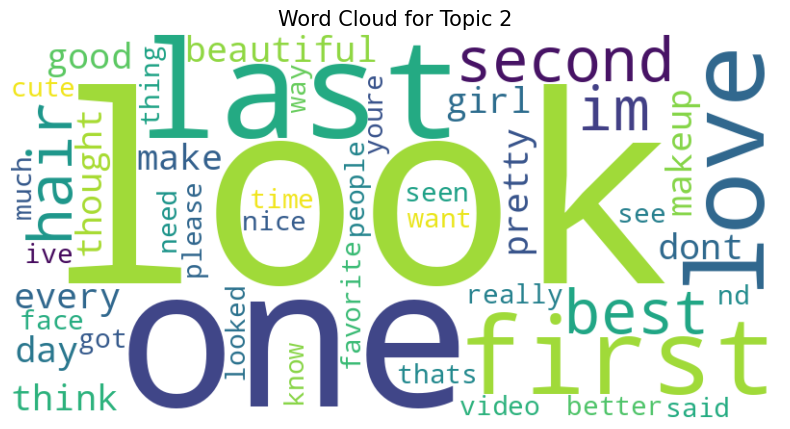

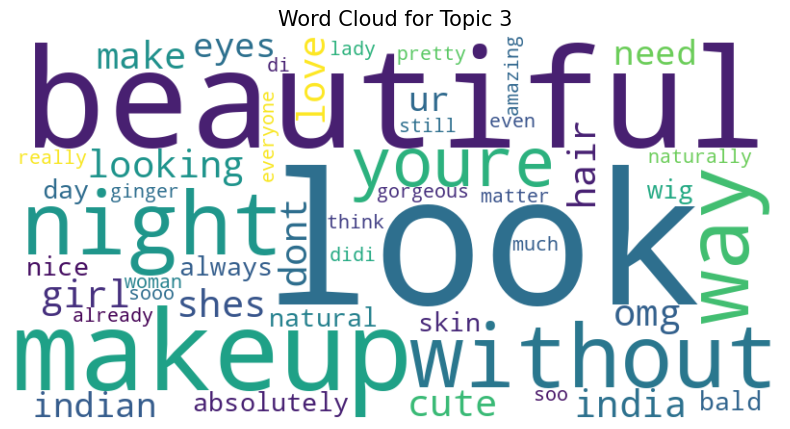

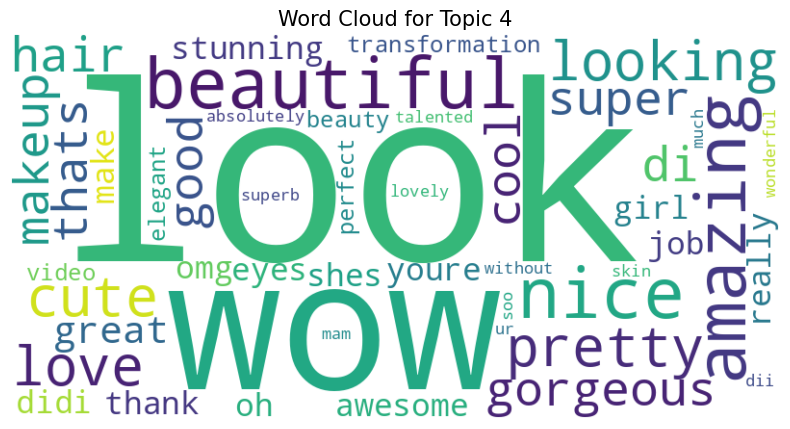

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have the 'terms' and 'order_centroids' from your topic modeling step
print("Generating Word Clouds for each topic...")

for i in range(num_topics):
    # Get the top 50 terms for the current topic
    topic_terms = " ".join([terms[ind] for ind in order_centroids[i, :50]])
    
    # Create the word cloud object
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white'
    ).generate(topic_terms)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Topic {i}', fontsize=15)
    plt.axis('off')
    plt.show()